<a href="https://colab.research.google.com/github/DS123-ally/EY_Hackathon/blob/main/EY_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
df = pd.read_csv("/content/2018-03-26_Seat_Leon_S_RT_Stau.csv")
df.head()
df.info()
df.describe()
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19510 entries, 0 to 19509
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Time                                       19510 non-null  object 
 1   Engine Coolant Temperature [°C]            19510 non-null  int64  
 2   Intake Manifold Absolute Pressure [kPa]    19509 non-null  float64
 3   Engine RPM [RPM]                           19508 non-null  float64
 4   Vehicle Speed Sensor [km/h]                19507 non-null  float64
 5   Intake Air Temperature [°C]                19506 non-null  float64
 6   Air Flow Rate from Mass Flow Sensor [g/s]  19505 non-null  float64
 7   Absolute Throttle Position [%]             19504 non-null  float64
 8   Ambient Air Temperature [°C]               19503 non-null  float64
 9   Accelerator Pedal Position D [%]           19502 non-null  float64
 10  Accelerator Pedal Posi

Index(['Time', 'Engine Coolant Temperature [°C]',
       'Intake Manifold Absolute Pressure [kPa]', 'Engine RPM [RPM]',
       'Vehicle Speed Sensor [km/h]', 'Intake Air Temperature [°C]',
       'Air Flow Rate from Mass Flow Sensor [g/s]',
       'Absolute Throttle Position [%]', 'Ambient Air Temperature [°C]',
       'Accelerator Pedal Position D [%]', 'Accelerator Pedal Position E [%]'],
      dtype='object')

In [3]:
#data cleaning

In [4]:
# Convert time column
df['Time'] = pd.to_datetime(df['Time'])

# Handle missing values (linear interpolate)
df = df.interpolate(method='linear')

# Drop duplicates
df = df.drop_duplicates()

# Quick check
df.info()
df.isna().sum()



/tmp/ipython-input-1941673523.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19510 entries, 0 to 19509
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Time                                       19510 non-null  datetime64[ns]
 1   Engine Coolant Temperature [°C]            19510 non-null  int64         
 2   Intake Manifold Absolute Pressure [kPa]    19509 non-null  float64       
 3   Engine RPM [RPM]                           19508 non-null  float64       
 4   Vehicle Speed Sensor [km/h]                19507 non-null  float64       
 5   Intake Air Temperature [°C]                19506 non-null  float64       
 6   Air Flow Rate from Mass Flow Sensor [g/s]  19505 non-null  float64       
 7   Absolute Throttle Position [%]             19504 non-null  float64       
 8   Ambient Air Temperature [°C]               19503 non-null  float64       
 9   Accelerator Pedal

,0
Time,0
Engine Coolant Temperature [°C],0
Intake Manifold Absolute Pressure [kPa],1
Engine RPM [RPM],2
Vehicle Speed Sensor [km/h],3
Intake Air Temperature [°C],4
Air Flow Rate from Mass Flow Sensor [g/s],5
Absolute Throttle Position [%],6
Ambient Air Temperature [°C],7
Accelerator Pedal Position D [%],8


In [5]:
#feature engineering


In [6]:
pip install pandas numpy scikit-learn matplotlib joblib


In [7]:
# 1 - imports & file paths
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc
import joblib

DATA_FILE = "/content/2018-03-26_Seat_Leon_S_RT_Stau.csv"
PROCESSED_OUT = "outputs/processed_features.csv"
MODEL_DIR = "models"
os.makedirs("outputs", exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [8]:
# 2 - load data (if you've saved processed_features.csv, load that)
if os.path.exists(PROCESSED_OUT):
    df = pd.read_csv(PROCESSED_OUT)
    print("Loaded processed features from", PROCESSED_OUT)
else:
    # fallback: load raw CSV and recreate minimal features (same as earlier)
    raw = pd.read_csv(DATA_FILE)
    raw["Time"] = pd.to_datetime(raw["Time"], errors="coerce")
    # convert numeric columns
    for c in raw.columns:
        if c != "Time":
            raw[c] = pd.to_numeric(raw[c], errors="coerce")
    raw = raw.interpolate().ffill().bfill().drop_duplicates().reset_index(drop=True)

    # create features we used before
    df = pd.DataFrame()
    df["Time"] = raw["Time"]
    df["rpm"] = raw["Engine RPM [RPM]"]
    df["throttle"] = raw["Absolute Throttle Position [%]"]
    df["speed"] = raw["Vehicle Speed Sensor [km/h]"]
    df["maf"] = raw["Air Flow Rate from Mass Flow Sensor [g/s]"]
    df["coolant"] = raw["Engine Coolant Temperature [°C]"]

    df["rpm_diff"] = df["rpm"].diff().fillna(0)
    df["throttle_diff"] = df["throttle"].diff().fillna(0)
    df["speed_diff"] = df["speed"].diff().fillna(0)
    df["time_diff"] = df["Time"].diff().dt.total_seconds().fillna(0.1)
    df["acceleration_m_s2"] = (df["speed_diff"] / 3.6) / df["time_diff"]
    df["rpm_per_speed"] = df["rpm"] / (df["speed"].replace(0, np.nan).fillna(0) + 0.1)
    df["throttle_per_rpm"] = df["throttle"] / (df["rpm"].replace(0, np.nan).fillna(0) + 1)
    df["air_per_rpm"] = df["maf"] / (df["rpm"].replace(0, np.nan).fillna(0) + 1)

    # fuel-eff proxy using MAF / speed (if available)
    df["speed_kph"] = df["speed"].replace(0, np.nan)
    if not df["maf"].isna().all():
        df["fuel_eff_proxy"] = df["maf"] / df["speed_kph"]
    else:
        df["fuel_eff_proxy"] = (df["throttle"] * df["rpm"]) / df["speed_kph"].fillna(1)
    df["fuel_eff_proxy"] = df["fuel_eff_proxy"].replace([np.inf, -np.inf], np.nan).fillna(df["fuel_eff_proxy"].median())

    df["overheat"] = (df["coolant"] > 95).astype(int)

    # drop rows missing core features
    df = df.dropna(subset=["rpm","throttle","speed","fuel_eff_proxy"])
    df.to_csv(PROCESSED_OUT, index=False)
    print("Saved processed features to", PROCESSED_OUT)

print("Final df shape:", df.shape)
df.head()


/tmp/ipython-input-1824994355.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw["Time"] = pd.to_datetime(raw["Time"], errors="coerce")


Saved processed features to outputs/processed_features.csv
Final df shape: (19510, 17)


,Time,rpm,throttle,speed,maf,coolant,rpm_diff,throttle_diff,speed_diff,time_diff,acceleration_m_s2,rpm_per_speed,throttle_per_rpm,air_per_rpm,speed_kph,fuel_eff_proxy,overheat
0,2025-11-02 18:06:33.150,1003.0,83.5,17.0,7.13,90,0.0,0.0,0.0,0.100,0.0,58.654971,0.083167,0.007102,17.0,0.419412,0
1,2025-11-02 18:06:33.239,1003.0,83.5,17.0,7.13,90,0.0,0.0,0.0,0.089,0.0,58.654971,0.083167,0.007102,17.0,0.419412,0
2,2025-11-02 18:06:33.329,1003.0,83.5,17.0,7.13,90,0.0,0.0,0.0,0.090,0.0,58.654971,0.083167,0.007102,17.0,0.419412,0
3,2025-11-02 18:06:33.450,1003.0,83.5,17.0,7.13,90,0.0,0.0,0.0,0.121,0.0,58.654971,0.083167,0.007102,17.0,0.419412,0
4,2025-11-02 18:06:33.539,1003.0,83.5,17.0,7.13,90,0.0,0.0,0.0,0.089,0.0,58.654971,0.083167,0.007102,17.0,0.419412,0


In [9]:
# 3 - define features for regression & classification
feature_cols = [
    "rpm", "throttle", "speed",
    "rpm_diff", "throttle_diff", "speed_diff",
    "acceleration_m_s2", "rpm_per_speed", "throttle_per_rpm", "air_per_rpm"
]

# Ensure all feature cols exist
feature_cols = [c for c in feature_cols if c in df.columns]
print("Using features:", feature_cols)

# Regression target (predict fuel efficiency proxy)
y_reg = df["fuel_eff_proxy"]

# Classification target (overheat)
y_clf = df["overheat"]
print("Overheat class distribution:\n", y_clf.value_counts())


Using features: ['rpm', 'throttle', 'speed', 'rpm_diff', 'throttle_diff', 'speed_diff', 'acceleration_m_s2', 'rpm_per_speed', 'throttle_per_rpm', 'air_per_rpm']
Overheat class distribution:
 overheat
0    19510
Name: count, dtype: int64


In [10]:
#training the data


In [11]:
# ✅ Step 4 — Train/Test Split + Scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 🎯 Target variable (what we want to predict)
target = "coolant"

# 👉 Features (all columns except target)
X = df.drop(columns=[target, 'Time'])
y = df[target]

# ✅ Split into training (80%) & testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# ✅ Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


# ✅ Scale features — very important for ML performance
scaler = StandardScaler()

# Fit on training, transform both (best practice)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print("\n✅ Data successfully split, imputed & scaled")

Training set shape: (15608, 15)
Testing set shape: (3902, 15)

✅ Data successfully split, imputed & scaled


In [12]:
# Train Linear Regression Model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
lin_model = LinearRegression()

# Train the model
lin_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = lin_model.predict(X_test_scaled)

# ✅ Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Calculate regression "accuracy" style metric
accuracy = r2_score(y_test, y_pred) * 100
print(f"Approx Regression Accuracy: {accuracy:.2f}%")


print("✅ Linear Regression Training Complete")
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")
print(f"📊 R² Score: {r2:.4f}")


Approx Regression Accuracy: 39.89%
✅ Linear Regression Training Complete
📉 Mean Squared Error (MSE): 0.2760
📊 R² Score: 0.3989


In [13]:
#random forest Technique

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(" Random Forest Performance")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Approx Accuracy: {r2*100:.2f}%")


 Random Forest Performance
MSE: 0.0571
R²: 0.8756
Approx Accuracy: 87.56%


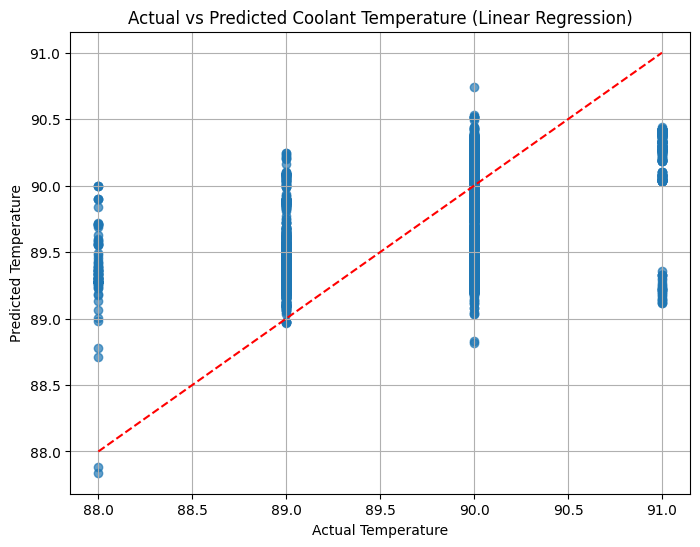

In [16]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted Coolant Temperature (Linear Regression)")
plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.grid(True)
plt.show()


In [17]:
#OverHeating Label Model
import pandas as pd
import numpy as np

# Target column
target_col = "coolant"

# Create overheating label: 1 = overheating, 0 = normal
df["overheat"] = np.where(df[target_col] > 100, 1, 0)
print(df["overheat"].value_counts())

overheat
0    19510
Name: count, dtype: int64


In [18]:
df["engine_load"] = (df["rpm"] * df["throttle"]) / 100000
df["temp_change"] = df["coolant"].diff().fillna(0)
df["fuel_efficiency"] = df["speed"] / (df["maf"] + 1e-5)
df["rpm_stress"] = df["rpm"] / (df["speed"] + 1)
df["throttle_jerk"] = df["throttle"].diff().fillna(0)
df["heat_per_speed"] = df["coolant"] / (df["speed"] + 1)
df["idle_heat"] = np.where((df["speed"]==0) & (df["coolant"]>90), 1, 0)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import numpy as np

# Features & target
X = df.drop(columns=["overheat", "Time"])
y = df["overheat"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train_imputed, y_train)

# Continuous predictions
y_pred_cont = lin_model.predict(X_test_imputed)

# Convert to binary 0/1
y_pred = (y_pred_cont > 0.5).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred) * 100, "%")
print(classification_report(y_test, y_pred))

Accuracy: 100.0 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3902

    accuracy                           1.00      3902
   macro avg       1.00      1.00      1.00      3902
weighted avg       1.00      1.00      1.00      3902



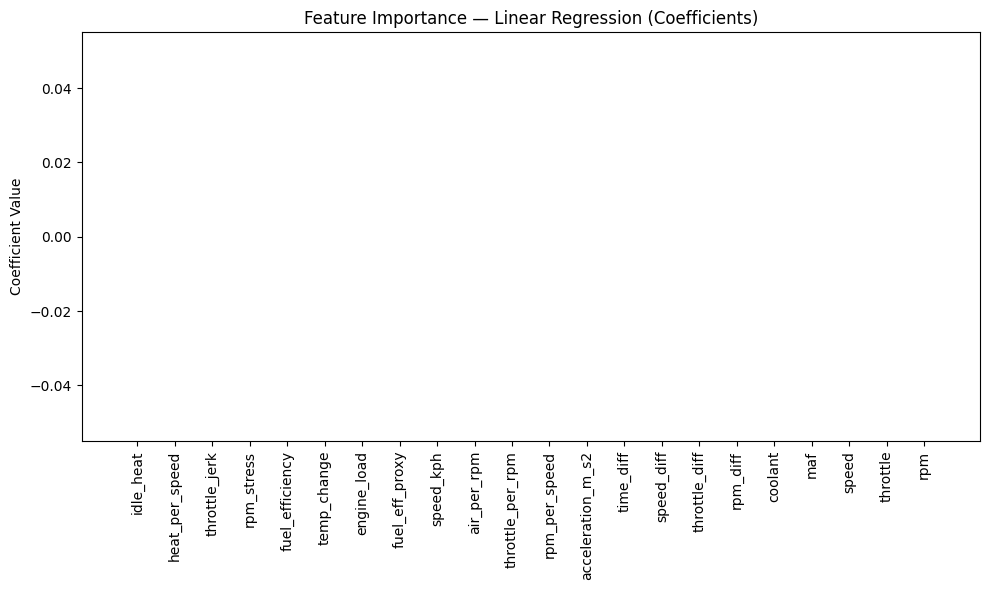

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Check if the model is trained
if 'lin_model' in locals() and hasattr(lin_model, 'coef_') and 'X' in locals():

    coefficients = lin_model.coef_
    features = X.columns

    # Sort by importance
    indices = np.argsort(np.abs(coefficients))[::-1]

    plt.figure(figsize=(10,6))
    plt.title("Feature Importance — Linear Regression (Coefficients)")
    plt.bar(range(len(coefficients)), coefficients[indices])
    plt.xticks(range(len(coefficients)), features[indices], rotation=90)
    plt.ylabel("Coefficient Value")
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Train 'lin_model' first and define 'X' before plotting feature importance.")


In [21]:
import pickle

# Save model
with open("overheat_model.pkl", "wb") as f:
    pickle.dump(lin_model, f)

# Save scaler (only if you used StandardScaler before training)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [22]:
import pickle

# Load model
with open("overheat_model.pkl", "rb") as f:
    model = pickle.load(f)

# Load scaler
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

print("✅ Model & Scaler Loaded")


✅ Model & Scaler Loaded
